In [1]:
# Necessary imports

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# loading data

import zipline
import pytz
from datetime import datetime

from zipline.utils.factory import load_bars_from_yahoo

# Load data manually from Yahoo! finance
start = datetime(2008, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2014, 1, 1, 0, 0, 0, 0, pytz.utc)
data = load_bars_from_yahoo(stocks=['AAPL'], start=start,
                            end=end)

AAPL


/usr/local/lib/python3.5/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [22]:
# Define our Algorithm. 

"""
An example would be:
Buy 1000 shares of AAPL when the stock crosses the 50 day moving average and 
then it croses the 200 day moving average etc. and also a sell code. 
"""

from zipline import TradingAlgorithm
from zipline.api import symbol, order, record, history, add_history, get_datetime

def initialize(context):
    
    # This algorithm has 2 window sizes. change the windows size below
    long_window = 200
    short_window = 50
    
    # don't change below
    context.aapl = symbol('AAPL')
    add_history(long_window, '1d', 'price')
    add_history(short_window, '1d', 'price')
    
    context.i = 0
    context.hasorder = False
    context.isupperS = False
    context.isupperL = False
    context.long_window = long_window
    context.short_window = short_window

def handle_data(context, data):
    
    context.i += 1
    if context.i <= 200:
        return
    
    loc_dt = get_datetime()

    prices = history(context.long_window, '1d', 'price')
    
    # only consider aapl
    price = data[context.aapl].price
    savg = pd.rolling_mean(prices[context.aapl], context.short_window).iloc[-1]
    lavg = pd.rolling_mean(prices[context.aapl], context.long_window).iloc[-1]

    # logic for enter long
    if not context.hasorder:
        if price >= savg and not context.isupperS:
            context.isupperS = True
        
        if price >= lavg and not context.isupperL:
            context.isupperL = True
            
        if context.isupperS and context.isupperL and not context.hasorder:
            order(symbol('AAPL'), 100)
            print('order aapl', loc_dt)
            context.hasorder = True
    # logic for exit long        
    else:
        if price < savg and context.isupperS:
            context.isupperS = False
        
        if price < lavg and context.isupperL:
            context.isupperL = False
            
        if not context.isupperL and not context.isupperS and context.hasorder:
            order(symbol('AAPL'), -100)
            print('sell aapl', loc_dt)
            context.hasorder = False 

In [23]:
algo = TradingAlgorithm(initialize=initialize, handle_data=handle_data)
results = algo.run(data)

order aapl 2001-06-25 00:00:00+00:00
sell aapl 2001-07-19 00:00:00+00:00
order aapl 2001-11-26 00:00:00+00:00
sell aapl 2002-06-07 00:00:00+00:00
order aapl 2003-05-05 00:00:00+00:00
sell aapl 2006-05-23 00:00:00+00:00
order aapl 2006-07-20 00:00:00+00:00
sell aapl 2006-12-21 00:00:00+00:00
order aapl 2007-01-04 00:00:00+00:00
sell aapl 2008-01-23 00:00:00+00:00
order aapl 2008-04-03 00:00:00+00:00
sell aapl 2008-06-12 00:00:00+00:00
order aapl 2008-06-16 00:00:00+00:00
sell aapl 2008-07-22 00:00:00+00:00
order aapl 2008-08-11 00:00:00+00:00
sell aapl 2008-09-04 00:00:00+00:00
order aapl 2009-04-09 00:00:00+00:00
sell aapl 2011-06-16 00:00:00+00:00
order aapl 2011-07-01 00:00:00+00:00
sell aapl 2011-11-25 00:00:00+00:00
order aapl 2011-12-05 00:00:00+00:00


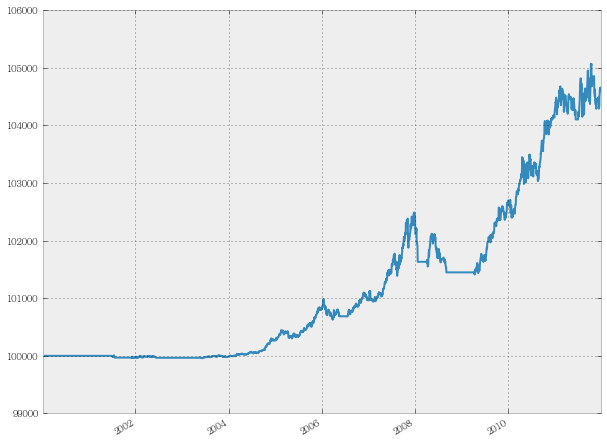

In [25]:
# plotting the portfolio value

plt.figure(figsize=(10, 8))

results.portfolio_value.plot()